In [416]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.constants import N_A
import seaborn as sns

In [417]:
Target_cell_number = 5e4
well_size = 50e-6
sigma = well_size*N_A/Target_cell_number
tumour_cell_radius = 7.25e-6
parameter_names=[r'$k_{on}$', r'$K_D$', r'$k_2$', 'C', 'noise1', 'noise2']
t_end = 60*60*100000
t = np.geomspace(1e-10, t_end, 50)
tspan = [1e-10, t_end]
A0s = np.geomspace(1e-12, 1e-3, 300)
kon = 1e5
KDs = [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7]
rtots = np.geomspace(1e3, 1e6, 300)

In [418]:
print(sigma)

602214076000000.0


In [419]:
def model_eqns(t, z, kon, KD, k2, rtot, Ainit):
    Atot = Ainit*sigma
    k1 = kon/sigma
    A0 = Atot - z[0] - z[1]
    r = rtot - z[0] - 2*z[1]

    dA1 = 2*k1*r*A0 - (KD*kon)*z[0] - k2*r*z[0] + 2*(KD*kon)*z[1]
    dA2 = k2*z[0]*r - 2*(KD*kon)*z[1]

    return [dA1, dA2]

def solve_model_individual(kon, KD, k2, rtot, A0s):
    solution = np.zeros_like(A0s)
    z0 = [0, 0]
    for i, Ainit in enumerate(A0s):
        z = solve_ivp(model_eqns, tspan, z0, method='Radau', t_eval=t, args=(kon, KD, k2, rtot, Ainit))
        A1 = z.y[0]
        A2 = z.y[1]
        bound_ab = A1[-1] + A2[-1]
        solution[i] = bound_ab
    
    return solution

def simulate_model(A0s, parameters):

    kon = parameters[0]
    KD = parameters[1]
    k2 = parameters[2]
    rtot = parameters[3]
    solution = np.zeros((len(A0s)))
    solution[:] = solve_model_individual(kon, KD, k2, rtot, A0s)

    return solution

def EC99_finder(array, A0s):
    half_max = 0.99*np.max(array)
    half_max_array = half_max*np.ones_like(array)
    indicies = np.argwhere(np.diff(np.sign(half_max_array-array)))
    return A0s[indicies]


def max_finder(array, A0s):
    indicies = np.argmax(array)
    return A0s[indicies]

In [420]:
k2s = [1e-6, 1e-5, 1e-4]
barrier = np.zeros((len(k2s), len(KDs), len(rtots)))

for k, k2 in enumerate(k2s):
    print(k)
    for i, KD in enumerate(KDs):
        for j, rtot in enumerate(rtots):

            parameters_biv=[kon, KD, k2, rtot]
            parameters_mono = [kon, KD, 0, rtot]
            mono_sol = simulate_model(A0s, parameters_mono)
            biv_sol = simulate_model(A0s, parameters_biv)
            max_mono = EC99_finder(mono_sol/rtot, A0s)
            max_biv = EC99_finder(biv_sol/rtot, A0s)
            barrier[k, i, j] = np.log10(max_mono/max_biv)
        

0


/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_21719/1581767254.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  barrier[k, i, j] = np.log10(max_mono/max_biv)


KeyboardInterrupt: 

/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_21719/40104711.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('Dark2')


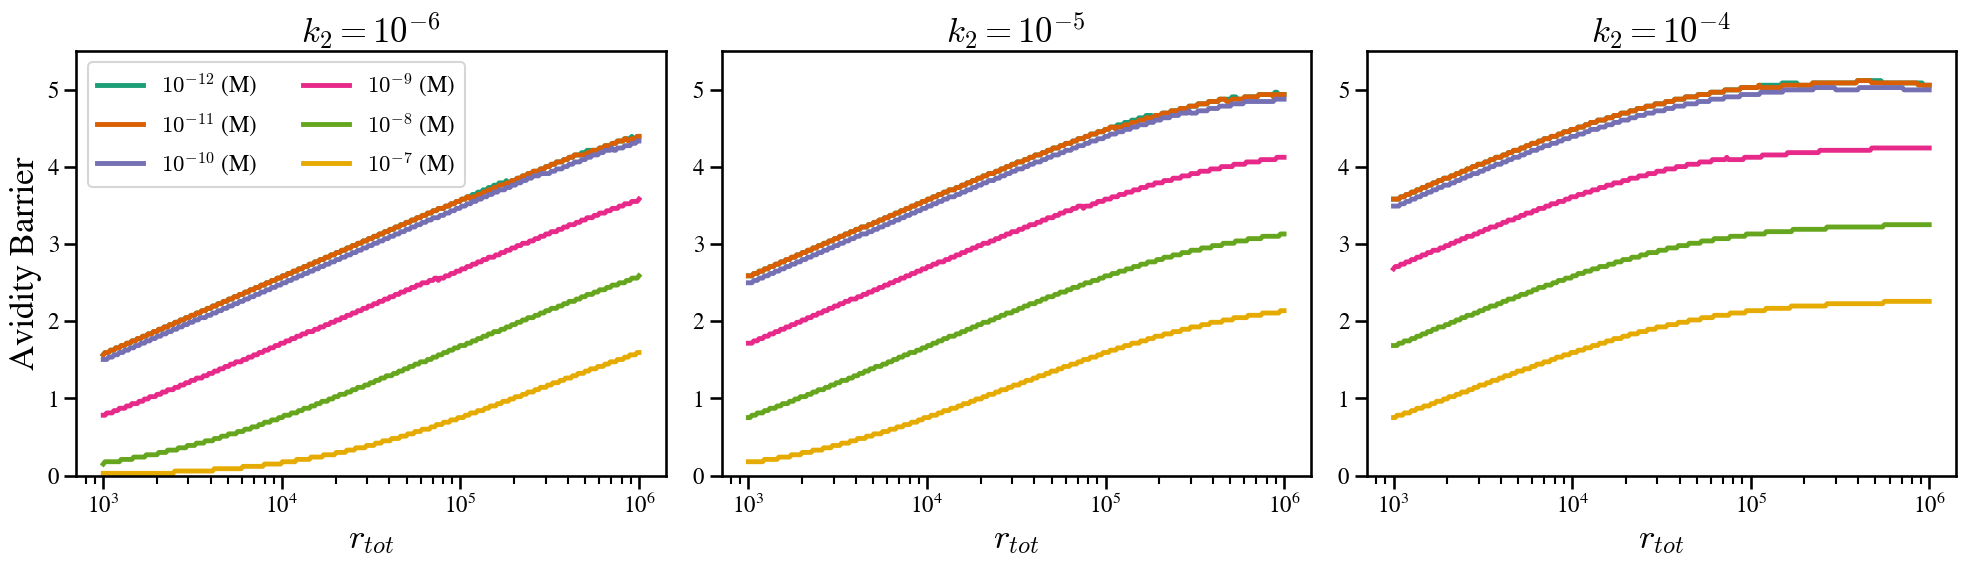

In [ ]:
barrier = np.abs(barrier)
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
labels =[r'$10^{-12}$ (M)', r'$10^{-11}$ (M)', r'$10^{-10}$ (M)', r'$10^{-9}$ (M)', r'$10^{-8}$ (M)', r'$10^{-7}$ (M)']
SMALL_SIZE =10
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
cm = plt.cm.get_cmap('Dark2')
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=BIGGER_SIZE)
sns.set_context('talk')
titles=[r'$k_2=10^{-6}$', r'$k_2=10^{-5}$', r'$k_2=10^{-4}$']
fig, ax = plt.subplots(1, 3, figsize=(20,6))

for i in range(len(k2s)):
    for j in range(len(KDs)):
        ax[i].semilogx(rtots, barrier[i, j, :], label=labels[j], c=cm(j), lw=3.5)
        ax[i].set_ylim([0, 5.5])
        ax[i].set_xlabel(r'$r_{tot}$', fontsize=25)
        ax[i].set_title(titles[i], fontsize=25)
ax[0].legend(loc='upper left', ncols=2)
ax[0].set_ylabel('Avidity Barrier', fontsize=25)
plt.tight_layout()

In [421]:
def bivalent_barrier(k2, kon, rtot, koff, alpha):

    K1 = kon/(sigma*koff)
    K2 = k2/koff
    K21 = K2/K1
    rtot = K2*rtot
    Kd = koff/kon
    a = 1
    b= 2+rtot - 2*alpha*rtot
    c = -2*alpha*rtot
    eta = (-b + np.sqrt(b**2 - 4*a*c))/(2*a)

    return (eta*Kd/2)*((eta**2 + 2*eta + 1 + (((rtot+1)**2)/K21))/((eta+1)*(rtot-eta)))

In [ ]:
print(bivalent_barrier(1e-5, 1e5, 1e3, 1e-4, 0.99))

2.4510322456177067e-06


In [422]:
def monovalent_barrier(kon, koff, rtot, alpha):

    KD = koff/kon

    return alpha*((rtot/sigma) + KD/(1-alpha))

In [ ]:
print(monovalent_barrier(1e5, 1e-4, 1e3, 0.99))

9.900164393367641e-08


In [431]:
k2s = [1e-6, 1e-5, 1e-4]
rtots = np.geomspace(1e2, 1e8, 300)
barrier = np.zeros((len(k2s), len(KDs), len(rtots)))
kon = 1e5
alpha = 0.99
for k, k2 in enumerate(k2s):
    print(k)
    for i, KD in enumerate(KDs):
        koff = KD*kon
        for j, rtot in enumerate(rtots):

            mono_bar = monovalent_barrier(kon, koff, rtot, alpha)
            biv_bar = bivalent_barrier(k2, kon, rtot, koff, alpha)
            barrier[k, i, j] = np.log10(biv_bar/mono_bar)
        

0
1
2


/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_21719/2954564807.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('Dark2')


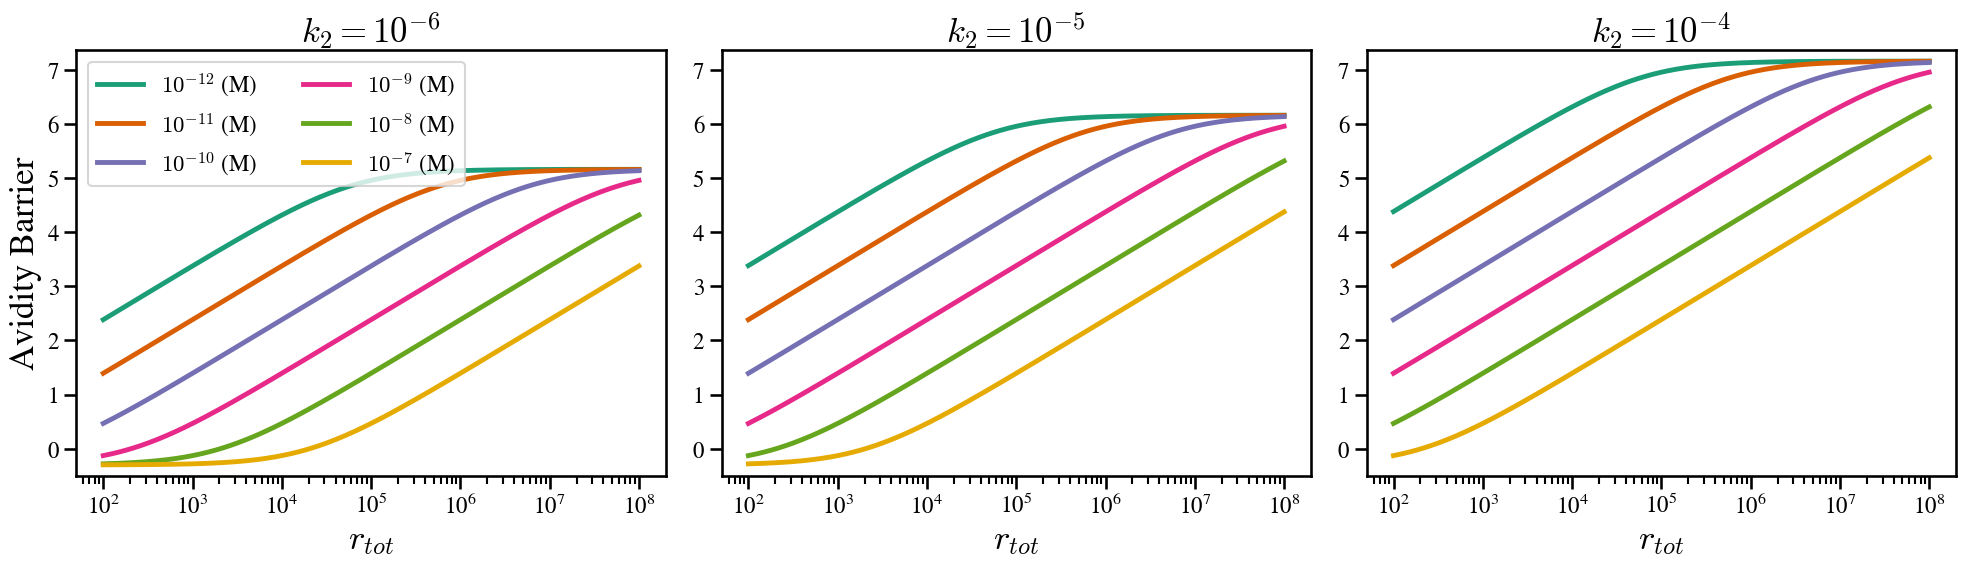

In [432]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
labels =[r'$10^{-12}$ (M)', r'$10^{-11}$ (M)', r'$10^{-10}$ (M)', r'$10^{-9}$ (M)', r'$10^{-8}$ (M)', r'$10^{-7}$ (M)']
SMALL_SIZE =10
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
cm = plt.cm.get_cmap('Dark2')
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=BIGGER_SIZE)
sns.set_context('talk')
titles=[r'$k_2=10^{-6}$', r'$k_2=10^{-5}$', r'$k_2=10^{-4}$']
fig, ax = plt.subplots(1, 3, figsize=(20,6))

for i in range(len(k2s)):
    for j in range(len(KDs)):
        ax[i].semilogx(rtots, barrier[i, j, :], label=labels[j], c=cm(j), lw=3.5)
        ax[i].set_ylim([np.min(barrier)-0.2,  np.max(barrier) + 0.2])
        ax[i].set_xlabel(r'$r_{tot}$', fontsize=25)
        ax[i].set_title(titles[i], fontsize=25)
ax[0].legend(loc='upper left', ncols=2)
ax[0].set_ylabel('Avidity Barrier', fontsize=25)
plt.tight_layout()

In [441]:
# agreement test

kon = 1e5
KD = 1e-8
k2 = 1e-4
rtot = 1e5
alpha=0.95
koff = KD*kon

parameters_biv=[kon, KD, k2, rtot]
parameters_mono = [kon, KD, 0, rtot]
mono_sol = simulate_model(A0s, parameters_mono)
biv_sol = simulate_model(A0s, parameters_biv)
mono_bar = monovalent_barrier(kon, koff, rtot, alpha)
biv_bar = bivalent_barrier(k2, kon, rtot, koff, alpha)

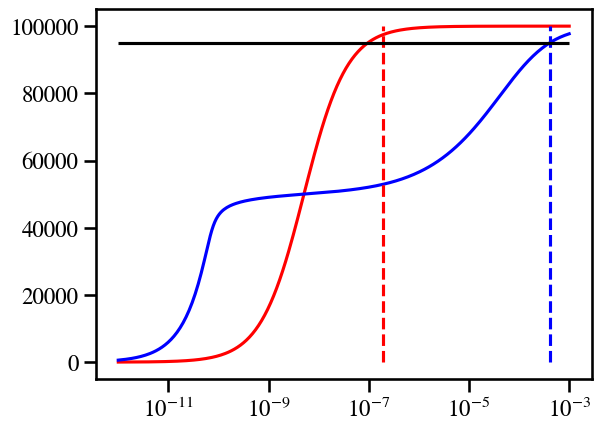

In [442]:
plt.semilogx(A0s, mono_sol, c='red')
plt.semilogx(A0s, biv_sol, c='blue')
plt.vlines(mono_bar, 0, rtot, color='red', linestyles='--')
plt.vlines(biv_bar, 0, rtot, color='blue', linestyles='--')
plt.hlines(alpha*rtot, A0s[0], A0s[-1], color='black')